# Example of application of the sdlabb package for metadata extaction
# NCOF method
Created 13-11-20

Author: Fredrik Möller 



# Install the alpacka package
## Through pip or through github

`pip install alpacka`

[Link to github repo](https://github.com/BernhardMoller/alpacka)

### Set up

To be able to use the alpacka package a data set for the analysis is needed. For this demo we will use the "Twitter US Airline Sentiment" data set. Availabe at https://www.kaggle.com/crowdflower/twitter-airline-sentiment

# Step by step guide for the NCOF pipeline

### TLDR without explenations, minimum of commands to go from input to output.

In [48]:
from alpacka.Pipeline import Pipeline
import pandas as pd
data = pd.read_csv('Tweets.csv')
score = data.airline_sentiment
score = pd.factorize(score)[0]

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

p = Pipeline(num_words=10000, class_perspective=2)
ncof, dictionary = p.ncof.calc_ncof(data.text, score,stop_words=stop_words)

inliers, pos_out, neg_out = p.ncof.split_score(ncof)

words_all = p.ncof.ind_2_txt(pos_out)

p.ncof.get_result(ncof,words_all)

 NCOF score added under 'self.score' use self.get_--- to access the result
 Inliers added under 'self.inliers' 
 Positive outliers added under 'self.pos_outliers' 
 Negative outliers added under 'self.neg_outliers' 
 use self.get_--- to access the result
Printing 1-sigma outliers, alphabetically sorted
####################
2: 0.0015798281215274072
3: 0.001281080118776339
delay: 0.0011050339863854744
due: 0.0008538631773265318
flightled: 0.0015003730826977132
hrs: 0.0013004276213544187
i've: 0.000848405460307582
late: 0.0015092446473041047
lost: 0.0009683690764148839
luggage: 0.0013237333553476089
minutes: 0.0011087654416230635
never: 0.0009202932776674045
no: 0.001153217040493423
rude: 0.0008488396444090059
sitting: 0.0010568187218005607
stuck: 0.0009783586747878015
system: 0.0008063932389948748
told: 0.0012180117105255609
####################
Printing 2-sigma outliers, alphabetically sorted
####################
call: 0.001952761485759505
delayed: 0.0025266299911870446
hour: 0.00226096

## Long version

### Load and preprocess the data 
Before you can apply the alpacka package you will need to load your for this demo we will not perform any data cleaning but this would be the time to do so.  

We also load some stop words that will be used later.


In [49]:
import pandas as pd
data = pd.read_csv('Tweets.csv')


from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


From the code we can see that the data has been loaded but the "airline_sentiment" are not integer labels, we need to fix this.

**IMPORTANT:** The alpacka package can only handle integer labels in the range of [0 n]. If your data set has labels in any other range you will need to translate them to the [0 n] range.

In [50]:
print(data.airline_sentiment[:10])
score = pd.factorize(data.airline_sentiment)
print(score[:10])
score= score[0]
print(score[:10])

0     neutral
1    positive
2     neutral
3    negative
4    negative
5    negative
6    positive
7     neutral
8    positive
9    positive
Name: airline_sentiment, dtype: object
(array([0, 1, 0, ..., 0, 2, 0], dtype=int64), Index(['neutral', 'positive', 'negative'], dtype='object'))
[0 1 0 2 2 2 1 0 1 1]


We can now see that the data is transformed from stings to integers in the range of [0 2]. With the mapping neutral: 0 , positive: 1, negative: 2.

### Importing and initiating alpacka
Now we are ready to import and initiate alpacka. 

In [1]:
from alpacka.Pipeline import Pipeline

p = Pipeline(num_words=10000, class_perspective = 2)

TypeError: __init__() got an unexpected keyword argument 'num_words'

There are some setting that we can make in the NCOF method that we need to specify before we start. One of which is how many unique tokens do we want to to take into consideration in the analysis, variable `num_words`. The defult setting for this variable is `None` meaning that all unique tokens will be used in the analysis. For "large" data sets this choice is quite ambitious given that the number of tokens that appear only once or twice in the a corpus. For this walkthrough we will limit the analysis to the $10,000$ most common words in the corpus.

Another setting that we need to specify is for what class we want the results presented for, variable `class_perspective`. As the NCOF method presents results regarding if a token is overrepresented in a class compared to the rest of the corpus, which class to investigate nees to be specified, the defult value of `class_perspective` is `1`. For this demo we have chosen the perspective of class 2 (negatives).

Now the `NCOF` pipeline is initiated through the wrapper `Pipeline` and the induvidual analysis methods can be accessed be calling:

`p.ncof.some_functions()`

Now we are ready to start the analysis of our data. 

Note that the  `.some_functions()` function is a placeholder and do exist.

#### Calculate NCOF
Now we are ready to calculate the NCOF score for the review data and its scores. This is done by calling the `.calc_ncof(data,labels)` function.  For this example the input in the `data` field is the texts, and the `labels` is the review scores. 

In [52]:
ncof, dictionary = p.ncof.calc_ncof(data.text, score)

 NCOF score added under 'self.score' use self.get_--- to access the result


Stop words can also automatically be removed from the NCOF calculating by passing a set of stop words in the `.calc_ncof` function. The reason you might want to remove stop words before NCOF calculations is due tothe stop words altering frequency distrubution of "value adding" words by by increasing the frequencylimit of when a word is considered as an NCOF outliers. Top top is to test with and without the stop word removal and you will see the difference. 

For this demo we keep the score where stop words has been removed.

In [53]:
ncof_score, dictionary = p.ncof.calc_ncof(data.text, score,stop_words=stop_words)

 NCOF score added under 'self.score' use self.get_--- to access the result


We now have an array, `ncof_score`, that contains the NCOF results for our data. This array will have the size `[1,num_words]` and positive and negatives values, indicating if a token is more or less common in investigated class (positives values), or the remaining classes (negative values).


In [54]:
print(ncof_score[:10])

[-0.03774483 -0.02481352 -0.01183599 -0.00601852 -0.01548369 -0.04066156
 -0.03846028 -0.00513828  0.00310846 -0.00088758]


In addition to an array with the scores the `.calc_ncof()` function returns a dictionary that maps the indexes in the  `ncof_score ` array to its text representations, and can be accessed by calling:

In [55]:
w = list(dictionary.items())[:10]
for item in w:
    print(item)

(0, 'i')
(1, '@united')
(2, 'flight')
(3, '@usairways')
(4, '@americanair')
(5, '@southwestair')
(6, '@jetblue')
(7, 'get')
(8, 'cancelled')
(9, 'customer')


#### Sorting results
To sort the array into inliers and outliers for the positive and negative values the function `.split_score()`needs to be called. The inliers can be accessed through:

**Important:** The the results returned as `pos_outliers` will containd the NCOF outliers that are identified from the class selected as the `class_perspective`. Meaning that they are positive from the perspective that are chosen, in out case we use a positive notation for the negative sentiment due to our selected class perspective.

In [56]:
inliers, pos_outliers,neg_outliers = p.ncof.split_score(ncof_score)

 Inliers added under 'self.inliers' 
 Positive outliers added under 'self.pos_outliers' 
 Negative outliers added under 'self.neg_outliers' 
 use self.get_--- to access the result


Which will return the indexes of the words in the dictionary that are considered as outliers in the NCOF results.

The results are sorted within the `ncof_pos `and `ncof_neg ` as the following:

ncof_pos[0] = $\mu+\sigma\leq result <\mu+2\sigma$
   
ncof_pos[1] = $\mu+2\sigma\leq result <\mu+3\sigma$
   
ncof_pos[2] = $\mu+3\sigma\leq result$
   
   
ncof_neg[0] = $\mu-\sigma\geq result >\mu-2\sigma$
   
ncof_neg[1] = $\mu-2\sigma\geq result >\mu-3\sigma$

ncof_neg[2] = $\mu-3\sigma\geq result$

#### Plotting results
These results can be plotted by calling the function `.scatter()` which will give visual information regarding what tokens are over or under represented in the investigated class. 

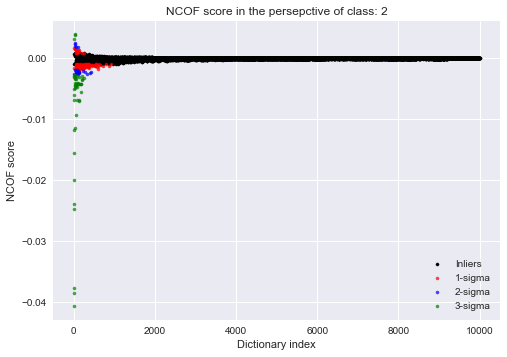

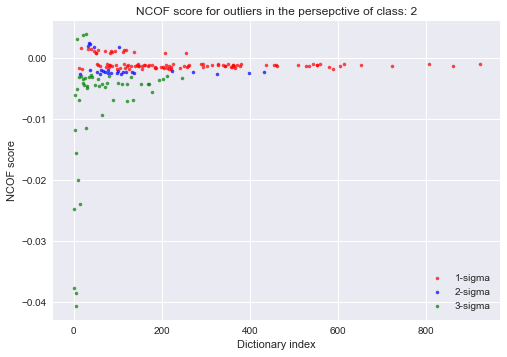

In [57]:
p.ncof.scatter(ncof_score, inliers, pos_outliers,neg_outliers)

#### Converting results from indexes to text
Since it is quite difficult to interpret the socre for each the indexes directly, it is suggested that the indexes are transformed back to their text representations. This can be done by calling the `.ncof.ind_2_txt(data)`function, the function input should be either indexes of the positive or negative outlers. 

In [58]:
words_pos = p.ncof.ind_2_txt(pos_outliers)

words_neg = p.ncof.ind_2_txt(neg_outliers)

If the text results want to be cleaned from stop words for clarification. The function `.remove_stop_words(data,stop_words)` can be called. This functon compares the content of the input `data` to that of the input `stop-words` and removes any matches between them from the `data`. For this walkthrough we will use the stop words available from the NLTK package.

We have already removed the stop words from the data set when we calculated the NCOF score, so we will not need to preform this step. That is why this part is commented out. 

In [59]:
# words_pos = p.ncof.remove_stop_words(words_pos,stop_words)
    
# words_neg = p.ncof.remove_stop_words(words_neg,stop_words)

#### Print results to terminal. 
We have now gone through all the steps required to produce, plot, and clean the reults from the NCOF analysis method. The last part is to either save the results to a file or to print them to the terminal. Since format to save the results to is a user preference no function for this is provided in the alpacka package, however the results can be printed to the terminal by calling the following function.

The input variable `sort` can be set to either `True` or `False` and decides if the results should be printed as alphabetically sorted or not. 
   

In [60]:
print(f"printing outliers from the investigated class")
p.ncof.get_result(ncof_score,words_pos, sort = True)
print(f" ")
print(f"printing outliers from the remaining classes")
p.ncof.get_result(ncof_score,words_neg, sort = True)

printing outliers from the investigated class
Printing 1-sigma outliers, alphabetically sorted
####################
2: 0.0015798281215274072
3: 0.001281080118776339
delay: 0.0011050339863854744
due: 0.0008538631773265318
flightled: 0.0015003730826977132
hrs: 0.0013004276213544187
i've: 0.000848405460307582
late: 0.0015092446473041047
lost: 0.0009683690764148839
luggage: 0.0013237333553476089
minutes: 0.0011087654416230635
never: 0.0009202932776674045
no: 0.001153217040493423
rude: 0.0008488396444090059
sitting: 0.0010568187218005607
stuck: 0.0009783586747878015
system: 0.0008063932389948748
told: 0.0012180117105255609
####################
Printing 2-sigma outliers, alphabetically sorted
####################
call: 0.001952761485759505
delayed: 0.0025266299911870446
hour: 0.0022609699128781813
waiting: 0.0017754783755518258
worst: 0.001895546879420585
####################
Printing 3-sigma outliers, alphabetically sorted
####################
cancelled: 0.0031084607382171206
hold: 0.003811